# Hierarchical Binomial Model: Rat Tumor Example

https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3.distributions.transforms as tr
import seaborn as ans
import theano.tensor as tt

import scipy.stats as stats
from scipy.special import gammaln 

print(f'Running on PyMC3 v{pm.__version__}')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.9.3


In [3]:
%config InlineBackend.figure_format = 'retina'
#az.style.use('arviz-darkgrid')

The rat tumour example found in chapter 5 of Bayesian Data Analysis 3rd Edition. Readers should already be familliar with the pymc3 api.

## Data from BDA3

- 71 trials, each trial has $n_i$ subjects resulting in $y_i$ cases of positive tumor.

In [4]:
# rat data (BDA3, p. 102)
# fmt: off
y = np.array([
    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
    1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
    5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])
# fmt: on

N = len(n)
print(f'Total {N} trials.')
print(f'In total, Tumor Rate = {sum(y)/sum(n):.2} for {sum(y)} out of {sum(n)} rats.')

Total 71 trials.
In total, Tumor Rate = 0.15 for 267 out of 1739 rats.


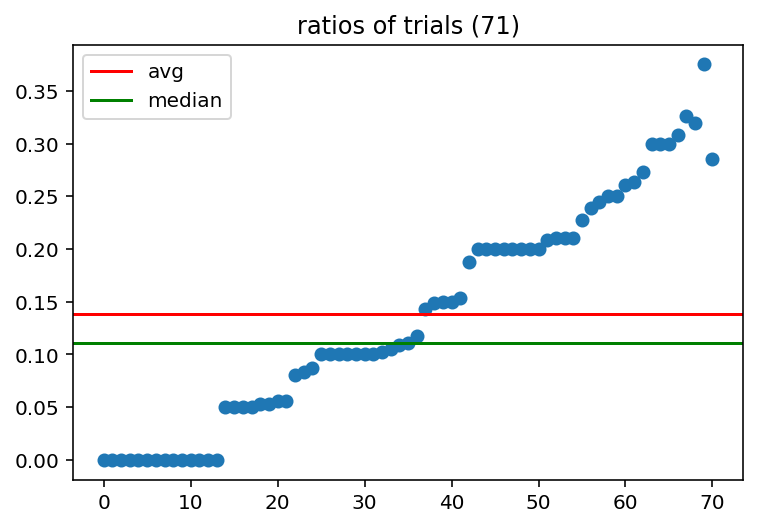

In [5]:
r = y / n
avg = r.mean()
median = np.median(r)

plt.plot(r, 'o')
plt.title(f'ratios of trials ({N})');
plt.axhline(y=avg, c='r', label='avg')
plt.axhline(y=median, c='g', label='median')
plt.legend();

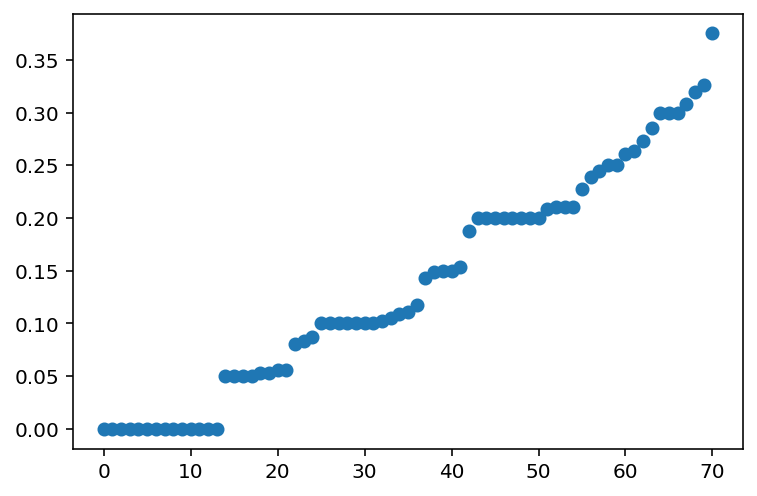

In [6]:
df = pd.DataFrame({'y': y, 'n':n})
df['r'] = df.y / df.n
df = df.sort_values(by='r')     # sort the data in accending order of r

y = df.y.values
n = df.n.values
r = df.r.values

plt.plot(r, 'o');

## 1. Beta - Binomial Conjugate Modeling for Each Trial

When each trial is modelled by beta-binomial conjugate pair,
$$
y_i \sim Binomial(n_i, \theta_i) \quad \Leftrightarrow \quad p(y_i | \theta_i) = Binomial(y_i | n_i, \theta_i) \\
\theta_i \sim Beta(\alpha_i, \beta_i) \quad \Leftrightarrow \quad p(\theta_i) = Beta(\theta_i| \alpha_i, \beta_i)
$$
the posterior is given by
$$
    p(\theta_i | y_i) = Beta(\theta_i | \alpha_i + y_i, \beta_i + n_i - y_i) \\
    = \frac{p(y_i|\theta_i) p(\theta_i | \alpha_i, \beta_i)}{ \int   }
$$

Here we do not need to perform integration to obtain the posterior distriubtion.

### Let's see about the case: n=47, y=15
- $\alpha_i$ = $\beta_i$ = 1 for a flat (non-informative) prior

In [7]:
n_i = n[-3]
y_i = y[-3]
print(f'y= {y_i} out of {n_i}: {y_i/n_i:.2}')
ai, bi = 1, 1
ap, bp = ai + y_i, bi + n_i - y_i

y= 15 out of 47: 0.32


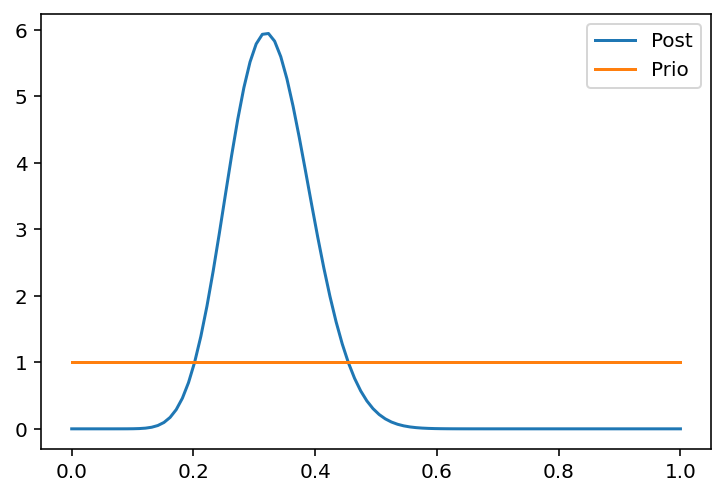

In [8]:
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta(a=ap, b=bp).pdf(x), label='Post');
plt.plot(x, stats.beta(a=ai, b=bi).pdf(x), label='Prio');
plt.legend();

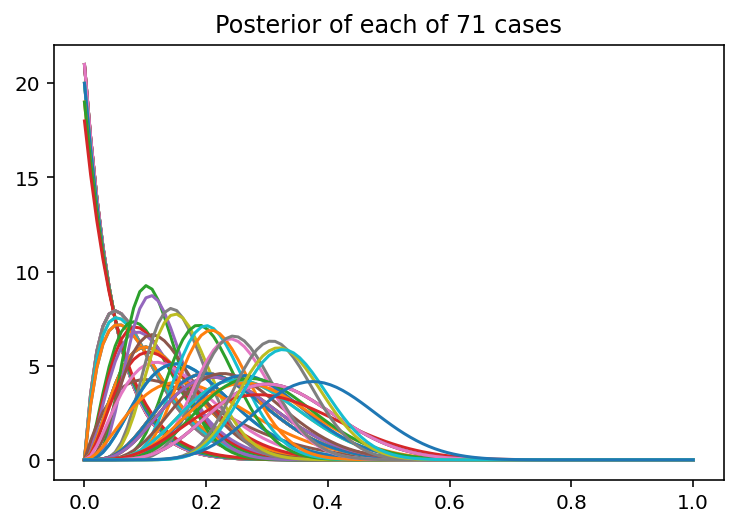

In [9]:
plt.figure()
plt.title(f'Posterior of each of {N} cases')
for yi, ni in zip(y, n):
#     print(f'y= {yi} out of {ni}: {yi/ni:.2}')
    ai, bi = 1, 1
    ap, bp = ai + yi, bi + ni - yi
    plt.plot(x, stats.beta(a=ap, b=bp).pdf(x), label=f'{yi}/{ni}');

## 2. Hierarchical Model

- Based on [Bayesian Inference and Decision Theory Unit 7: Hierarchical Bayesian Models by Kathryn Blackmond Laskey, George Mason University](http://seor.vse.gmu.edu/~klaskey/SYST664/SYST664.html)
- Here PyMC3 NUTS Sampling instead of Jags Gibbs Sampling

#### 2.1 Learning Objectives
- Specify hierarchical models (aks multi-level models) for comparing samples from subgroups of a population
    - Each sample consists of iid observations from a subgroup of a larger population
    - Parameters for the groups are viewed as a sample from a larger population of groups
    - Information can be shared across groups
- Explain the benefits of Bayesian hierarchical models for complex multi-parameter problems
- Inference in hierarchical models
- Evaluate structural assumptions in hierarchical models

#### 2.2 Hierarchical Models
- Use structural assumptions to achieve better statistical power without sacrificing realism
    - Parameters are often related to each other by structure of the problem
    - Hierarchical models exploit the relationship
    - "Borrow strength" from data used to estimate related parameters
    - Flexibly adapt dimensionality of model to exploit the information in the data
- Address tension between realism and statistical power
    - different from frequentist inference requiring too many parameters for realistic models
    - frequentist method not recommended; well I knot know exactly why.

#### 2.3 Rat Tumors
- BDA3 Section 5.1 - 5.3, Gelman, et.al.
- Studies are commonly performed on rats to evaluate effects of drugs
- The observations come from a set of 71 studies; rats were given a substance and evaluated for the presence of tumors
    - $y_s$ is the number of rats out of $n_s$ rats in the $s$-th study which developed tumors
    - Model for $y_s$:
        - Tumors occur indenpendently with probability $\theta_s$
        - $y_s$ is drawn from a Binomial($n_s$, $\theta_s$)
    - The **question of interest** is whether $\theta_s$s are different for different studies.
- Modeling choices:
    1. Pool all data and estimate a single tumor probability
        - not supported by the data
    1. Independent analyses for each of the 71 studies
        - low statistical power, especially for studies with small sample size
    1. Hierarchical model
        - gives us benefits of both approaches without drawbacks of either

#### 2.4 Pooled Model of Tumor Probability

- Pooled model:
    - All studies have the same probability $\theta$ of each rat developing tumor
    - Uniform beta(1,1) prior for $\theta$
    - Observations: 267 out of 1739 rats have tumors
    - Posterior is also a beta with:
    $$
        \begin{align}
        \alpha^* & =  1 + \sum_s y_s \\
        \beta^*  & = 1 + \sum_s n_s - \sum_s y_s
        \end{align}
    $$
    - Posterior expected probability (mean) a rat will have a tumor
    $$
        \mathbb{E}[\theta|Y] = \bar\theta_{|Y} = \frac{\alpha^*}{\alpha^* + \beta^*} = 0.154 \quad \mbox{where } Y=\{y_s\}
    $$
    - Posterior predictive distribution for a new study of size $n$ is beta-binomial with probability 0.154, size $n$, and overdispersion 1741.
        - beta-binomial distribution $f(k|n,\alpha^*, \beta^*)$:
            $$
                f(k|n,\alpha^*, \beta^*) = \int_0^1 \mathrm{beta}(\theta|\alpha^*, \beta^*) \mathrm{Bin}(k|\theta)d\theta
            $$
            
        - This is nearly identical to binomial distribution with MAP point estimate:
        $$
            \mathrm{Bin}(n | \bar\theta_{|Y})
        $$

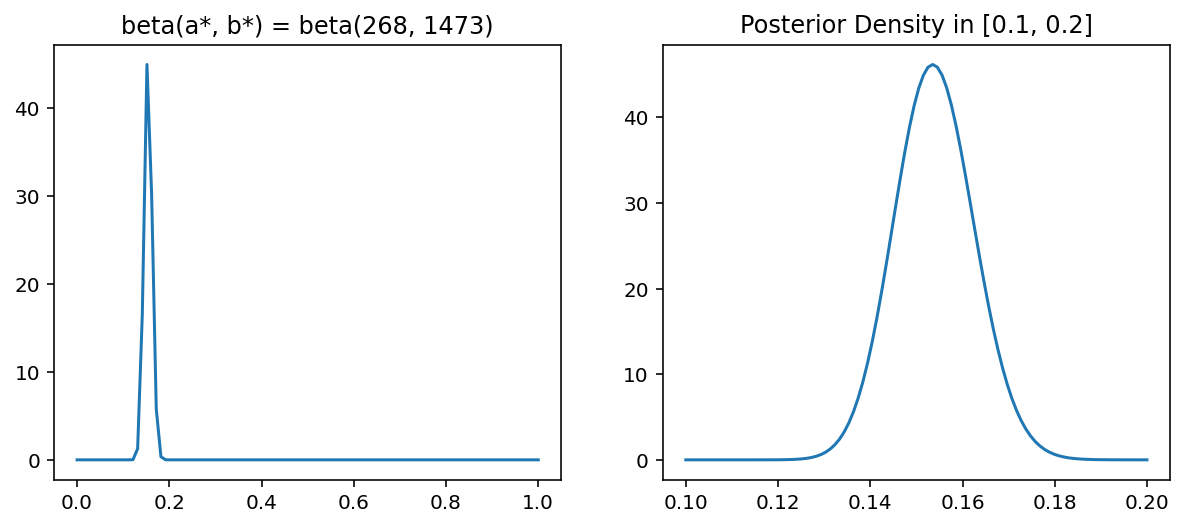

In [10]:
a, b = 1, 1
astar = 1 + sum(y)
bstar = 1 + sum(n) - sum(y)
post_pool = stats.beta(a=astar, b=bstar)

fig, axes = plt.subplots(1,2, figsize=(10,4))
x=np.linspace(0, 1, 100)
pdf = post_pool.pdf(x)
axes[0].plot(x, pdf);
axes[0].set_title(f'beta(a*, b*) = beta({astar}, {bstar})')
lb, ub = .1, .2
x=np.linspace(lb, ub, 100)
pdf = post_pool.pdf(x)
axes[1].plot(x, pdf);
axes[1].set_title(f'Posterior Density in [{lb}, {ub}]');

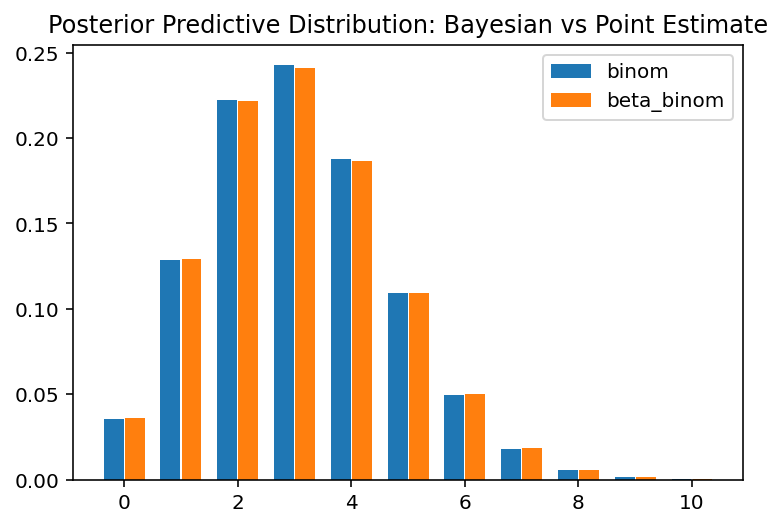

In [11]:
# posterior predictive distribution; nnew = 20
n_new = 20  # if a new study is performed with this number of rats

theta_pmean = astar / (astar + bstar)   # posterior mean
binom = stats.binom(n=n_new, p=theta_pmean)  # binomial from Point Estimate (MAP)
beta_bin = stats.betabinom(n=n_new, a=astar, b=bstar)  # Posterior Averaged

k = np.arange(0, 11); k
binom_pmf = binom.pmf(k)
bb_pmf = beta_bin.pmf(k)
width = .35
plt.bar(k - width/2 - .01, binom_pmf, width=width, label='binom')
plt.bar(k + width/2 + .01, bb_pmf, width=width, label='beta_binom')
plt.legend()
plt.title('Posterior Predictive Distribution: Bayesian vs Point Estimate');

#### 2.5 Posterior Predictive Evaluation of Pooled Model
- Posterior predictive distribution for a new study of size $n$ is beta-binomial (or beta with MAP estimate)
- Compare observed tumor counts in the 71 studies with posterior expected counts for 71 new studies with same sample sizes
- There are more studies with zero or more than 12 tumors than expected by the posterior predictive analysis
- This suggests that different studies may have different tumor probabilities
    - Some very small and some very larger

In [12]:
# Posterior predictive evaluation
# We repeat the study 100 times; that is 100 simulations and make average
def study():
    klist = []
    for ys, ns in zip(y, n):
    #     print(ns)
        # define posterior predictive distribution
        ppd = stats.betabinom(n=ns, a=astar, b=bstar)
        # generate k, the number of tumor cases
        k = ppd.rvs()  # instead, we may generate 100 rvs at once, which should be much faster
        klist.append(k)
    return np.array(klist)
#
n_simul = 100
karray = np.array([ study() for _ in range(n_simul) ] ); karray.shape

(100, 71)

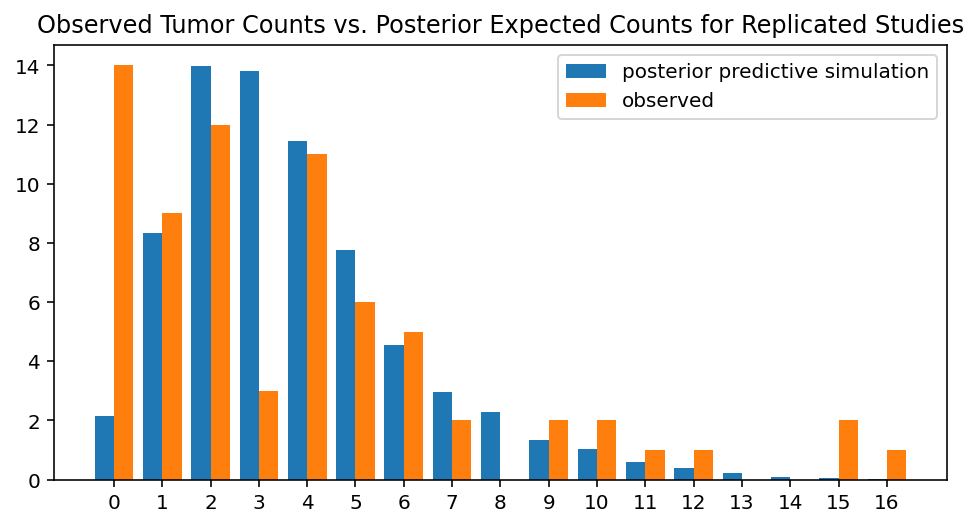

In [13]:
plt.figure(figsize=(8,4))
width = .4  # for bar graph

kcnt, kvals = np.histogram(karray.ravel(), bins=range(18))
kavg = kcnt / 100.
plt.bar(kvals[:-1] - width/2, kavg, width=width, label='posterior predictive simulation')

cnt, kvals = np.histogram(y, bins=range(18))
plt.bar(kvals[:-1] + width/2, cnt, width=width, label='observed')

plt.legend()
plt.title('Observed Tumor Counts vs. Posterior Expected Counts for Replicated Studies')
plt.xticks(range(17));

#### 2.6 Sample Frequencies and Posterior Predictive Intervals for Sample Frequencies
- Compute 90% posterior predictive interval for each $n_s$ given $\theta_{|Y}$
- Examine whether the observation $y_s$ is included in the interval for each study

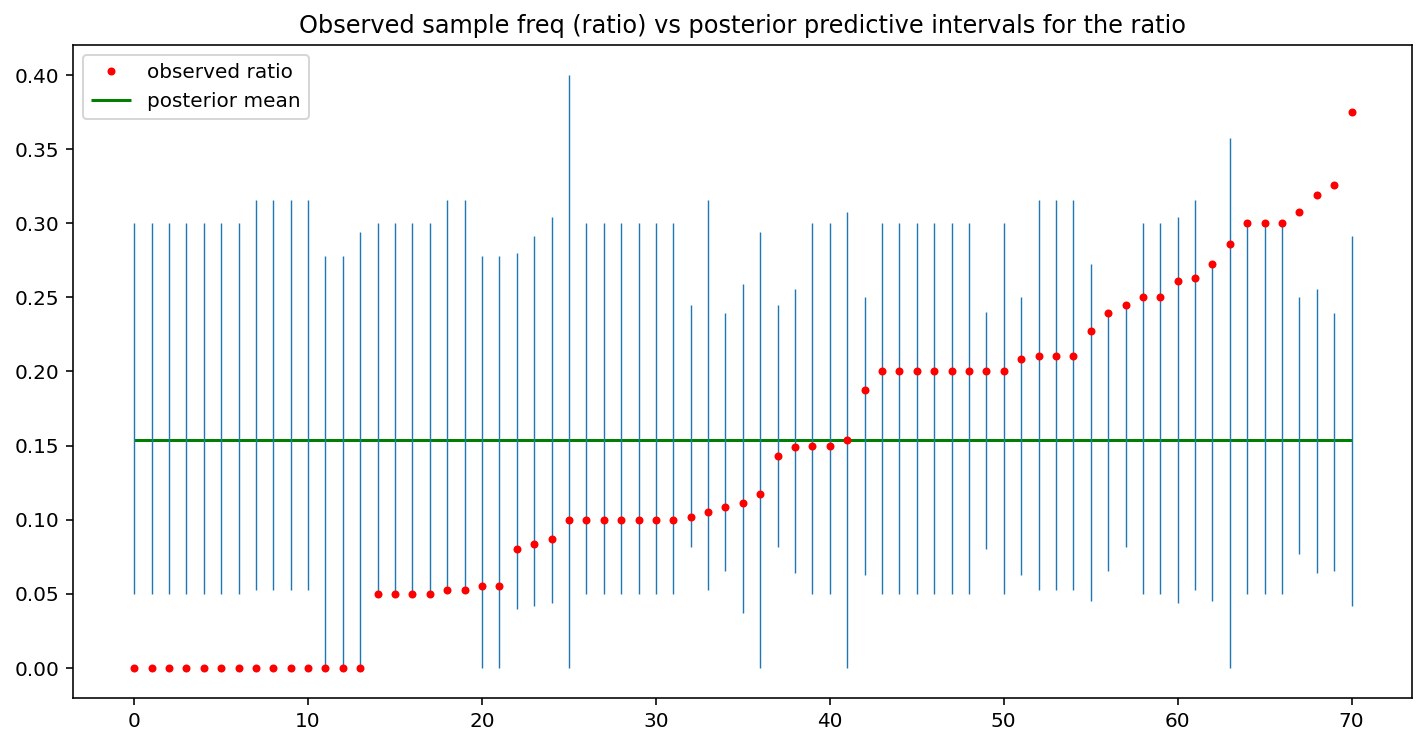

In [14]:
plt.figure(figsize=(12,6))
plt.hlines(y=theta_pmean, xmin=0, xmax=len(n)-1, color='g', label='posterior mean')
plt.plot(y/n, 'r.', label='observed ratio')
outside = []
for i, (ys, ns) in enumerate(zip(y, n)):
    post_s = stats.betabinom(n=ns, a=astar, b=bstar)  # find l, u such that P[ l <= k <= u ] = 90%
    lb, ub = post_s.ppf([.05, .95])
    mm, MM = lb/ns, ub/ns   # compute the ratio for the given n_s
    plt.vlines(x=float(i), ymin=mm, ymax=MM, linewidth=.7)       
    outside.append( not( mm <= ys/ns <= MM ) )
plt.legend();
plt.title('Observed sample freq (ratio) vs posterior predictive intervals for the ratio');

In [15]:
sum(outside)

15

- 90% of 71 cases are expected to lie inside the interval; in other words, 10% of 71, that is, 7 cases are expected to lie outside the 90% predictive interval.
- Sample frequencies for 15 out of 71 studies lie outside 90% posterior predictive interval.
- **The pooled model is a poor fit to the observations**

#### 2.7 Pooled and Separate Analyses
- Compare a study case with the pooled analysis
- Considered is a case where $n_s=25$, $y_s=2$.

In [16]:
# one of the study cases
i=22
ys, ns = y[i], n[i]
print(ys, ns)

2 25


posterior mean: 0.11 == 0.11


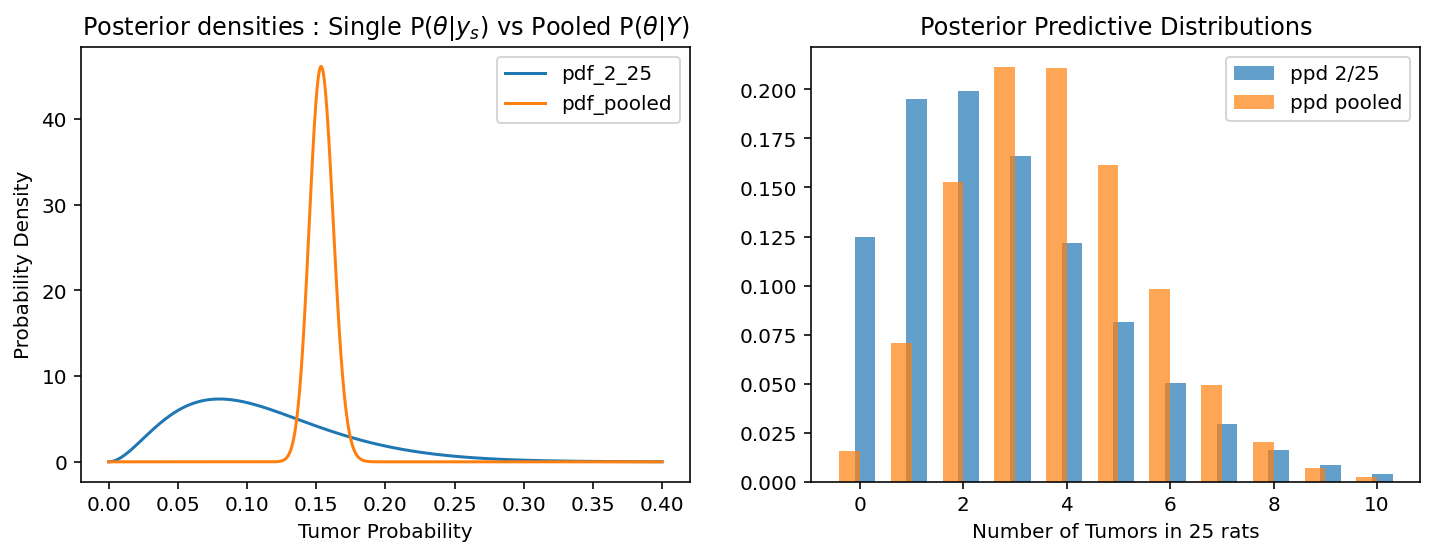

In [17]:
# the posterior is simply beta
post_2_25 = stats.beta(a=1+ys, b=1+ns-ys)
print(f'posterior mean: {post_2_25.mean():.2} == {(1+ys)/(2+ns):.2}')

x=np.linspace(0, .4, 1000)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
# posterior densities
pdf_2_25 = post_2_25.pdf(x)
pdf_pool = post_pool.pdf(x)
axes[0].plot(x, pdf_2_25, label='pdf_2_25');
axes[0].plot(x, pdf_pool, label='pdf_pooled');
axes[0].set_ylabel('Probability Density')
axes[0].set_xlabel('Tumor Probability')
axes[0].set_title(f'Posterior densities : Single P($θ|y_s$) vs Pooled P($θ|Y$)')
axes[0].legend();

# posterior predictive distributions
k = np.arange(0,11)
ppd_pool = stats.betabinom(n=ns, a=astar, b=bstar)
pmf_pool = ppd_pool.pmf(k)
ppd_2_25 = stats.betabinom(n=ns, a=1+ys, b=1+ns-ys)
pmf_2_25 = ppd_2_25.pmf(k)

width = .4
axes[1].bar(k+width/2-.1, pmf_2_25, label='ppd 2/25', width=width, alpha=.7);
axes[1].bar(k-width/2, pmf_pool, label='ppd pooled', width=width, alpha=.7);
axes[1].set_title('Posterior Predictive Distributions')
axes[1].set_xlabel(f'Number of Tumors in {ns} rats')
axes[1].legend();

- Posterior mean is given by $ \bar\theta|y_s = \frac{1+y_s}{2+n_s}$ = 0.11.
- More wide-spread and more weight closer to zero.
- Much better in representing the data set; but may be not for other data sets.
---

#### 2.8 Hierarchical Model for Rat Tumor Example

$$
    \begin{align}
    p(y, \theta) & = p(y|\theta)p(\theta) \quad\quad\mbox{two level model (likelihood * prior)}\\
    p(y,\theta, \alpha, \beta) & = p(y,\theta | \alpha, \beta) p(\alpha, \beta) \\
        & = p(y|\theta)p(\theta|\alpha, \beta)p(\alpha, \beta) \quad\mbox{three level model (likelihood * prior * hyper-prior)}
    \end{align}
$$

<img src="figs/dag_hierarchical_rat_tumor.png" width="150">

- The data $Y=\{y_1, ..., y_{71} \}$:
    - $y_s$s are independent draws from a Binom($n_s$, $\theta_s$)
        $$
            y_s \sim \mathrm{binom}(\theta_s)
        $$
    - The tumor probabilities $\theta_s$ may vary due to differences in rats and experimental conditions.
- The Parameters $\Theta = \{ \theta_1, ..., \theta_{71} \}$:
    - $\theta_s$s are modeled to be samples form a distribution
        $$
            \theta_s \sim \mathrm{beta}(\alpha_s, \beta_s)
        $$
    - In pooled model, $\alpha$, $\beta$ were set to fixed constant numbers to build up a prior distribution.
    - $\alpha_s$ and $\beta_s$ are drawn from another distribution function $g(U, V)$
        $$
            \alpha, \beta \sim g(U, V)
        $$
    - Another level to provide variability of $\alpha, \beta$ - the hyper-parameters.

#### 2.9 Hyperparameter Prior

- beta distribution has several alternative parametrizations [Wikipedia](https://en.wikipedia.org/wiki/Beta_distribution)
    - Reparametrizaton by  mean and sample size
        - mean $\mu$ in (0, 1): $\mu = \frac{\alpha}{\alpha + \beta}$, which corresponds to the expected tumor probability.
        - sample size: $v = \alpha + \beta > 0$, virtual count for population
            $$
            \begin{align}
                \alpha & = u v \\
                \beta & = (1 - u) v
            \end{align}
            $$
            - $\theta_s|\alpha(u,v), \beta(u,v)$ should be independent.
        - $v$ is to model the distribution of the (average) number of samples $n_s$ in a study (not directly).
            - $v \sim \mathrm{Gamma}(k, scale)$
            - See below for density graph.
            - the posterior should be insensitive to the choice of $k$ and $scale$.
        - $u$ is to model the the probability $\theta_s$
            - so, $u \sim \mathrm{Uniform}(0,1)$ is to model our non-informative prior for $\theta_s$
    - Uncertainty in $u$ and $v$ allows the studies to share information
        - If $u$ and $v$ were given then $\theta_s$ would be independent.
        - Each study contributes to posterior distribution of $(u,v)$, which then affects distribution for other $\theta_s$s.

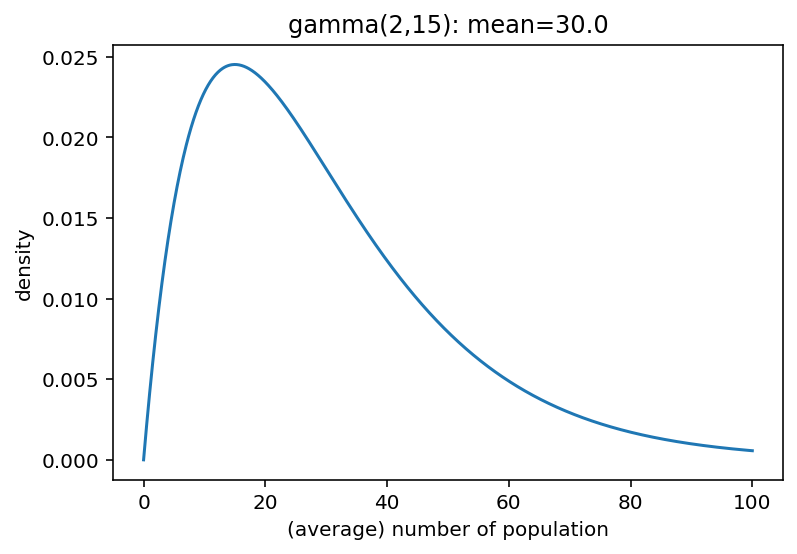

In [18]:
x = np.linspace(0,100,1000)
k_gamma, s_gamma = 2, 15
gamma = stats.gamma(a=k_gamma, scale=s_gamma)
plt.plot(x, gamma.pdf(x));
plt.ylabel('density')
plt.xlabel('(average) number of population')
plt.title(f'gamma({k_gamma},{s_gamma}): mean={gamma.mean():.1f}');

In [19]:
gamma.ppf(.1), gamma.mean(), gamma.ppf(.90)

(7.977174125844179, 30.0, 58.345802548011434)

In [20]:
n.min(), n.mean(), n.max()

(10, 24.492957746478872, 52)

#### 2.10 Modeling with PyMC3

In [21]:
with pm.Model() as model:
    u = pm.Uniform('u', lower=0., upper=1.)    # hyper-prior
    v = pm.Gamma('v', alpha=k_gamma, beta=1./s_gamma)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, u]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [22]:
trace.varnames

['u_interval__', 'v_log__', 'u', 'v']

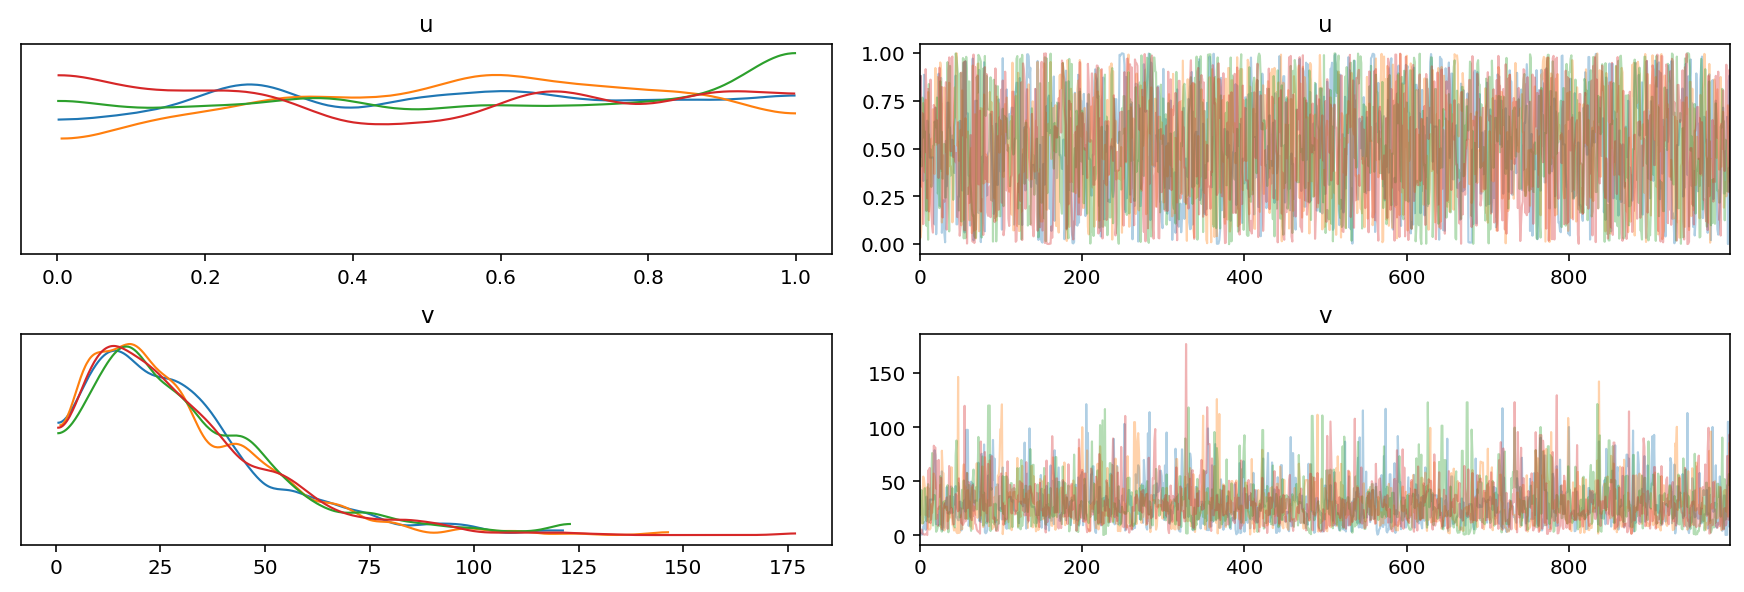

In [23]:
# check if the pymc model produces samples as we planned.
with model:
    az.plot_trace(trace)

In [24]:
with pm.Model() as model:
    u = pm.Uniform('u', lower=0., upper=1.)    # hyper-prior
    v = pm.Gamma('v', alpha=k_gamma, beta=1./s_gamma)
    
    alpha = pm.Deterministic('alpha', u * v)
    beta = pm.Deterministic('beta', (1 - u) * v)
    
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=N)  # prior, we need N thetas
    
    likely = pm.Binomial('y', n=n, p=theta, observed=y)   # likelihood with observation

In [25]:
y

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  5,  2,
        5,  3,  2,  7,  7,  3,  3,  2,  9,  4,  4,  4,  4,  4,  4, 10,  4,
       10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  4,  6,  6,  6, 16,
       15, 15,  9])

In [26]:
with model:
    trace = pm.sample()  # draw samples from posterior p(u,v | y, n)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, v, u]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [27]:
trace.varnames

['u_interval__',
 'v_log__',
 'theta_logodds__',
 'u',
 'v',
 'alpha',
 'beta',
 'theta']

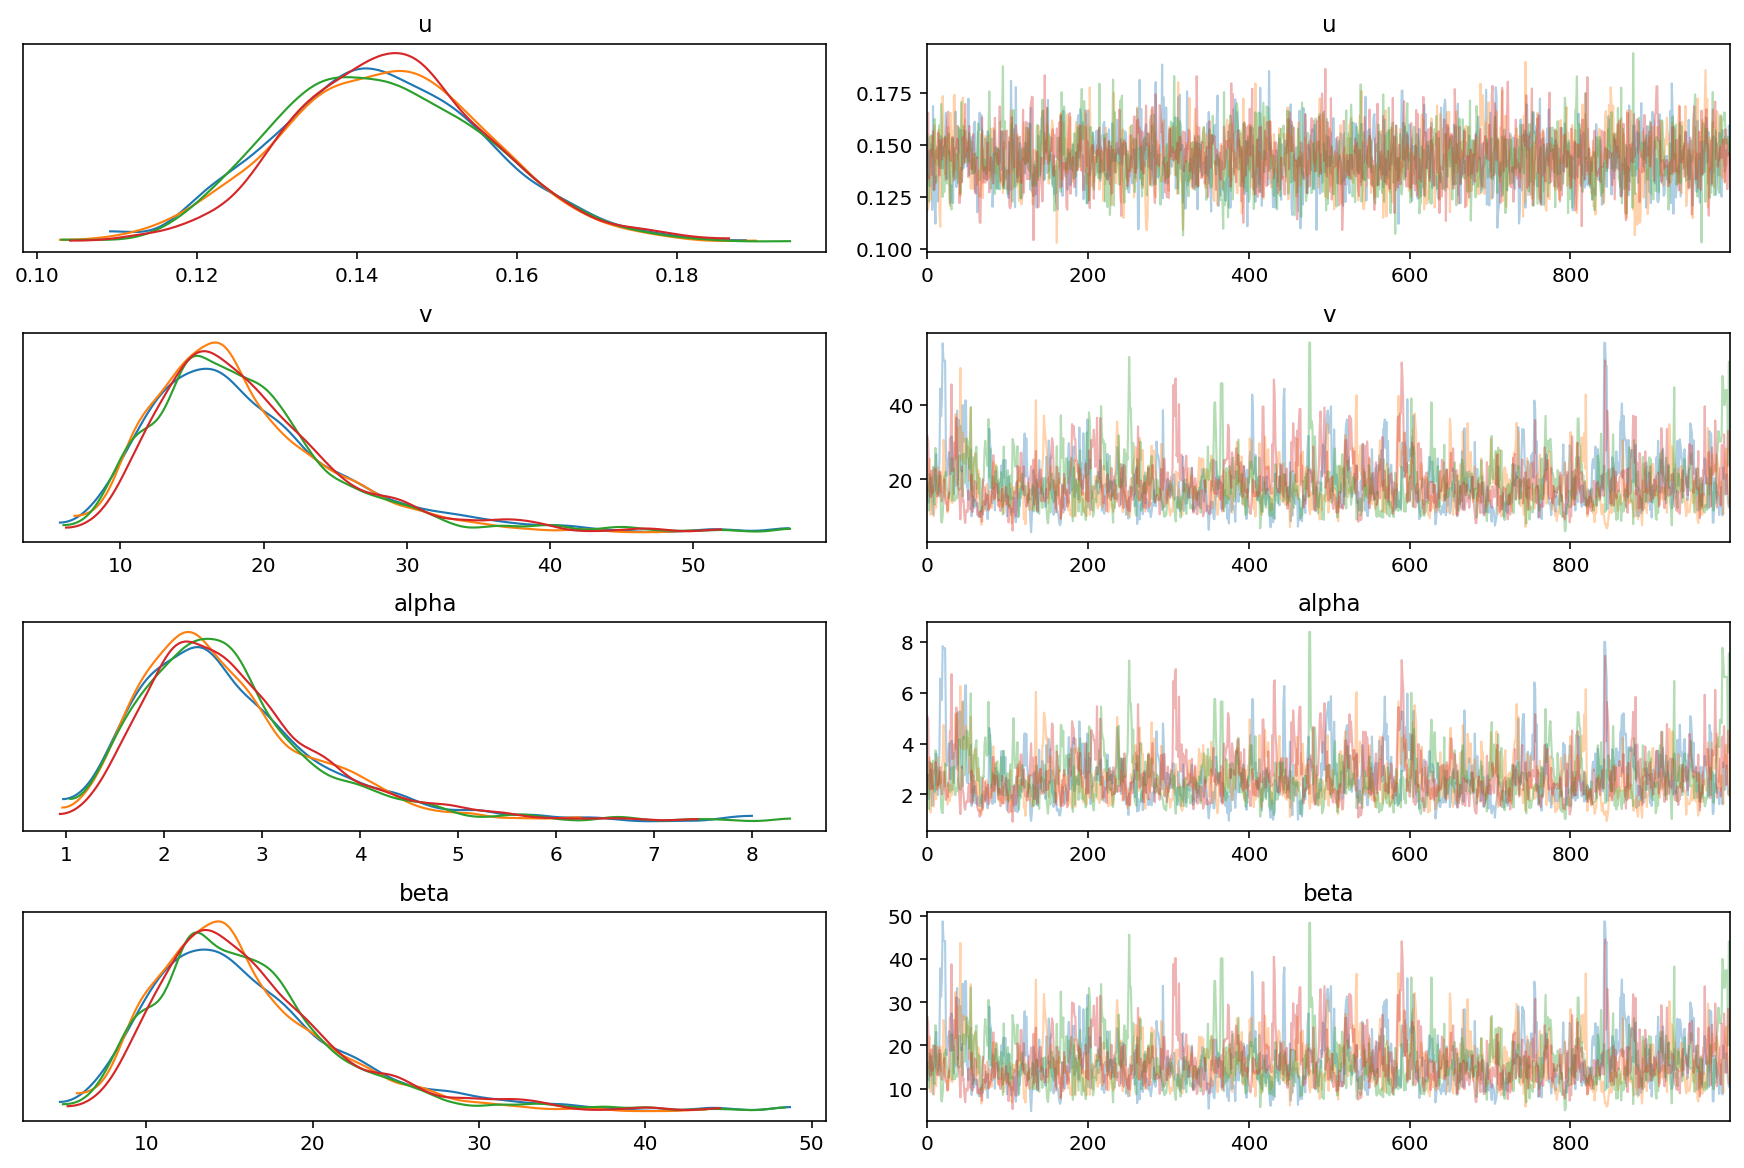

In [28]:
with model:
    az.plot_trace(trace, var_names=['u', 'v', 'alpha', 'beta'])

#### 2.11 Population Hyperparameter Posterior Distribution
- MCMC estimte of $u$ and $v$

In [29]:
with model:
    tu_mean = trace['u'].mean()
    print(f'MCMC estimate of posterior mean of u is {tu_mean:.3f}')
    print(f'Pooled model\'s posterior mean: {theta_pmean: .3f}')
    print(f'Average of ys/ns: {sum(r)/N:.3f}')

MCMC estimate of posterior mean of u is 0.144
Pooled model's posterior mean:  0.154
Average of ys/ns: 0.138


Text(0.5, 0, 'p(v|y,n): expected virtual sample size')

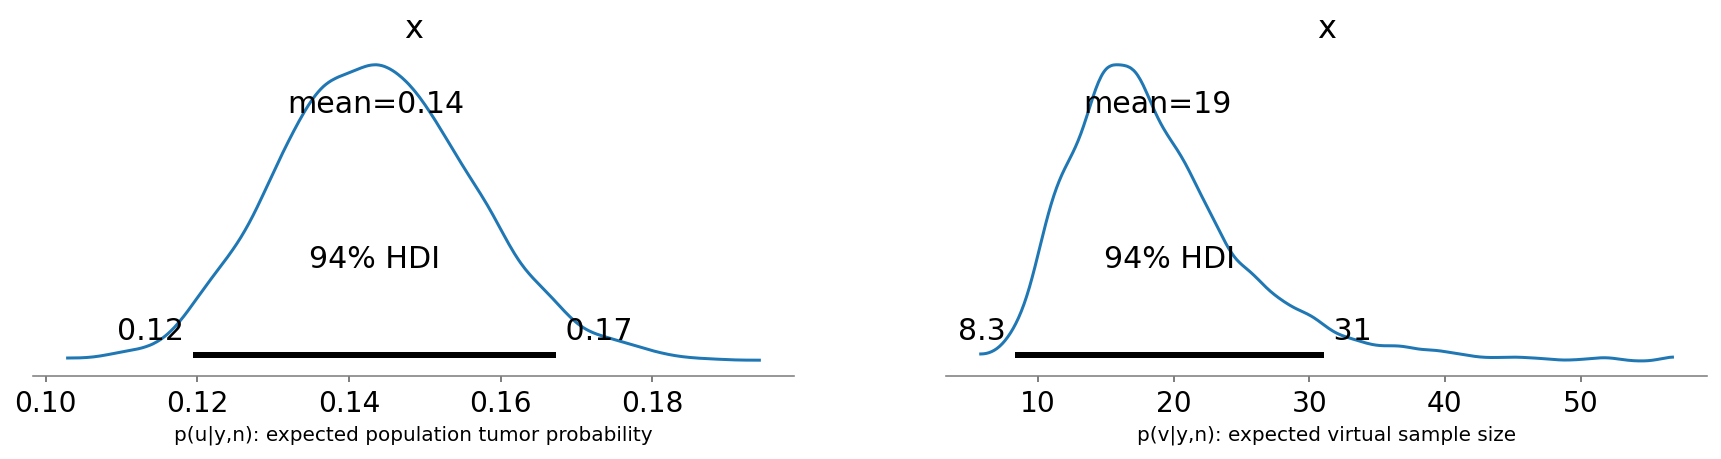

In [30]:
trace_u = trace['u']
type(trace_u), trace_u.shape
fig, axes = plt.subplots(1,2, figsize=(15,3))
az.plot_posterior (trace['u'], ax=axes[0]);
axes[0].set_xlabel('p(u|y,n): expected population tumor probability')
az.plot_posterior(trace['v'], ax=axes[1]);
axes[1].set_xlabel('p(v|y,n): expected virtual sample size')

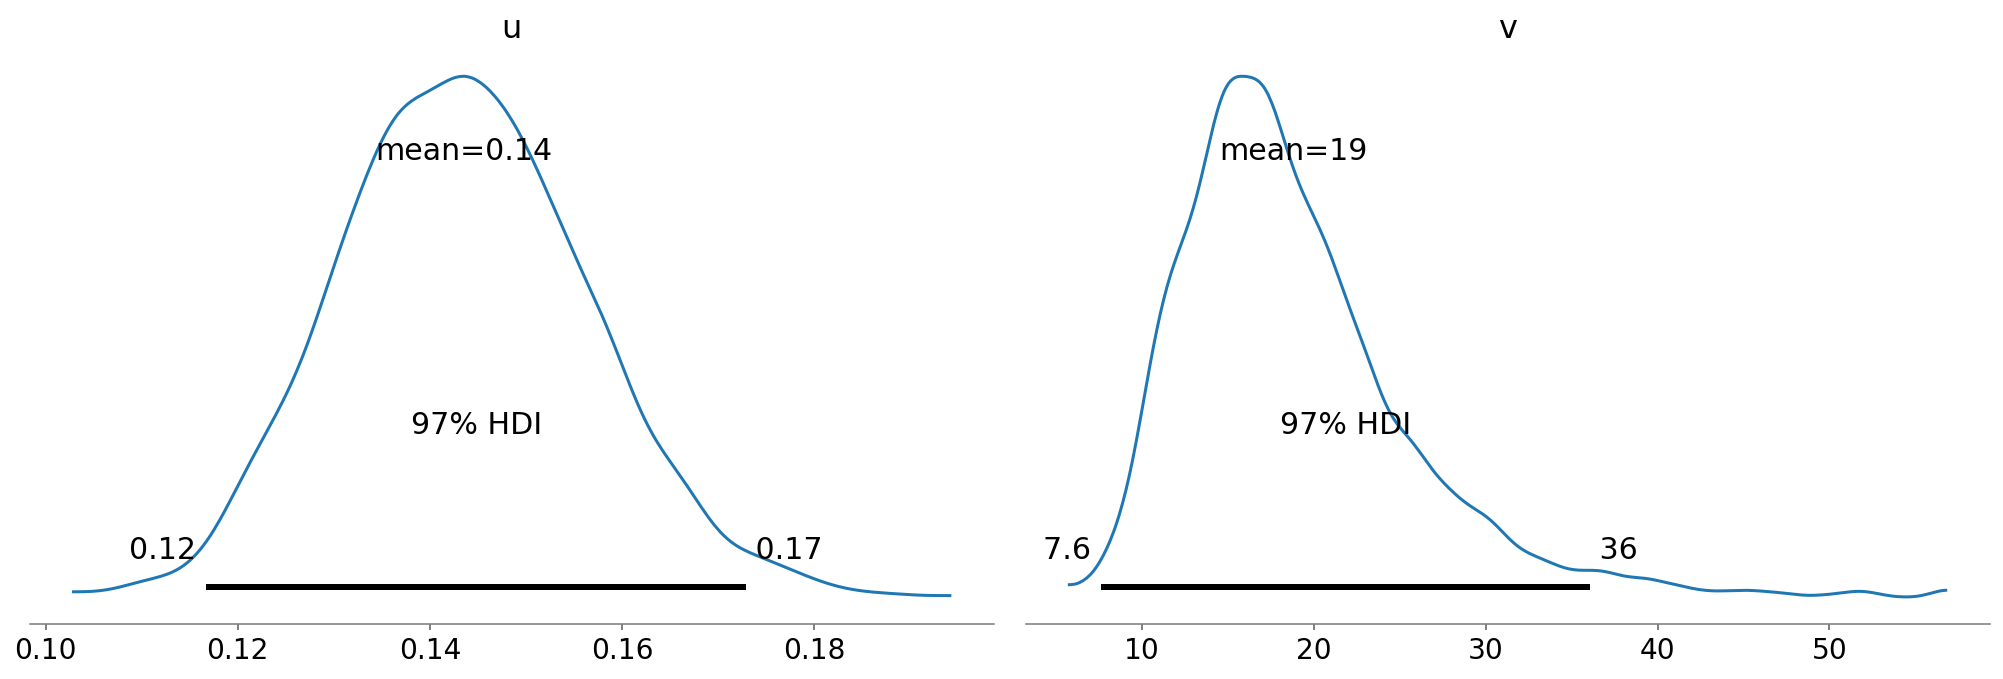

In [31]:
# the plot above can be drawn with arviz.
with model:
    az.plot_posterior(trace, var_names=['u', 'v'], hdi_prob=.97)

##### 2.1.1 Check the result of posterior with different settings of hyper-prior parameters

In [34]:
k_gamma_2, s_gamma_2 = 1, 30
with pm.Model() as model2:
    u2 = pm.Uniform('u', lower=0., upper=1.)    # hyper-prior
    v2 = pm.Gamma('v', alpha=k_gamma_2, beta=1./s_gamma_2)
    
    trace2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, u]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


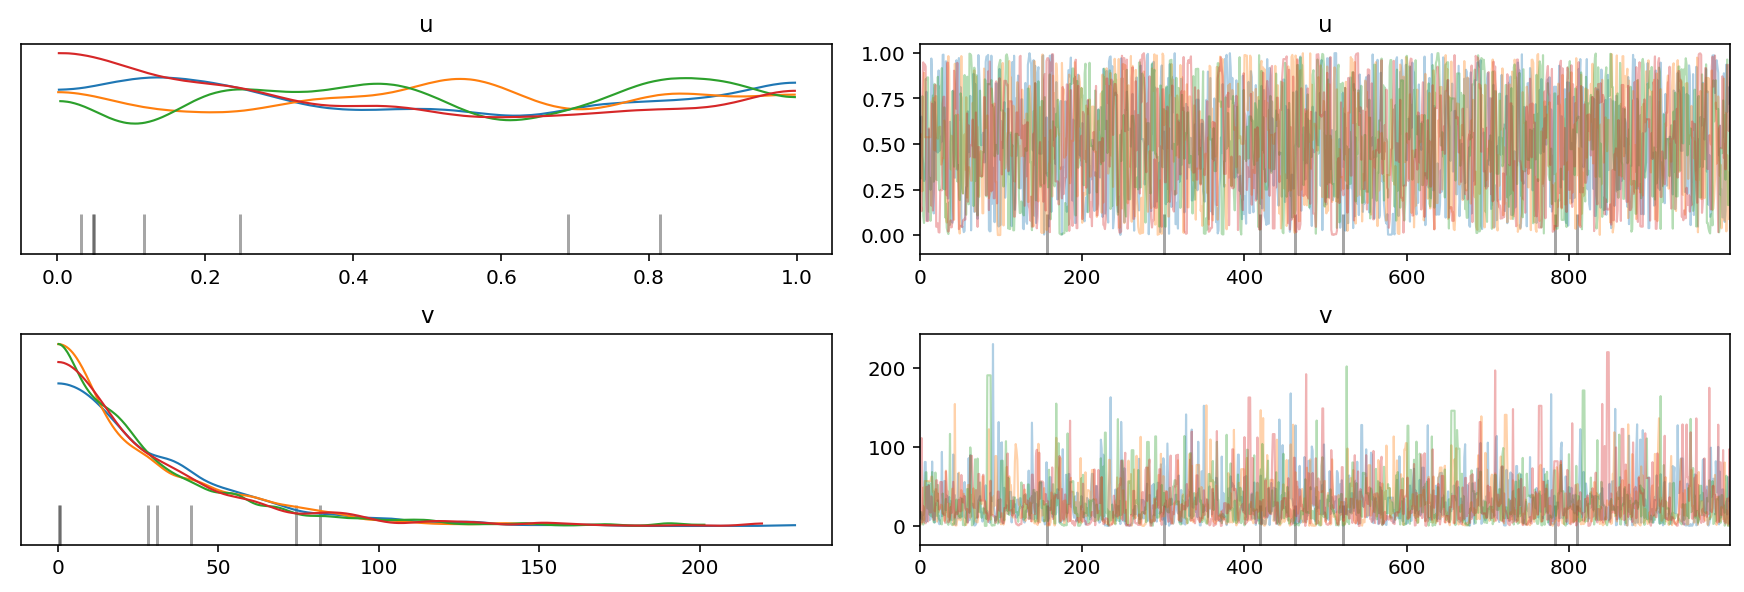

In [35]:
# check if the pymc model produces samples as we planned.
with model2:
    az.plot_trace(trace2)

In [36]:
with pm.Model() as model2:
    u2 = pm.Uniform('u', lower=0., upper=1.)    # hyper-prior
    v2 = pm.Gamma('v', alpha=k_gamma_2, beta=1./s_gamma_2)
    
    alpha2 = pm.Deterministic('alpha', u2 * v2)
    beta2 = pm.Deterministic('beta', (1 - u2) * v2)
    
    theta2 = pm.Beta('theta', alpha=alpha2, beta=beta2, shape=N)  # prior, we need N thetas
    
    likely2 = pm.Binomial('y', n=n, p=theta2, observed=y)   # likelihood with observation

In [37]:
with model2:
    trace2 = pm.sample()  # draw samples from posterior p(u,v | y, n)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, v, u]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [39]:
trace2.varnames

['u_interval__',
 'v_log__',
 'theta_logodds__',
 'u',
 'v',
 'alpha',
 'beta',
 'theta']

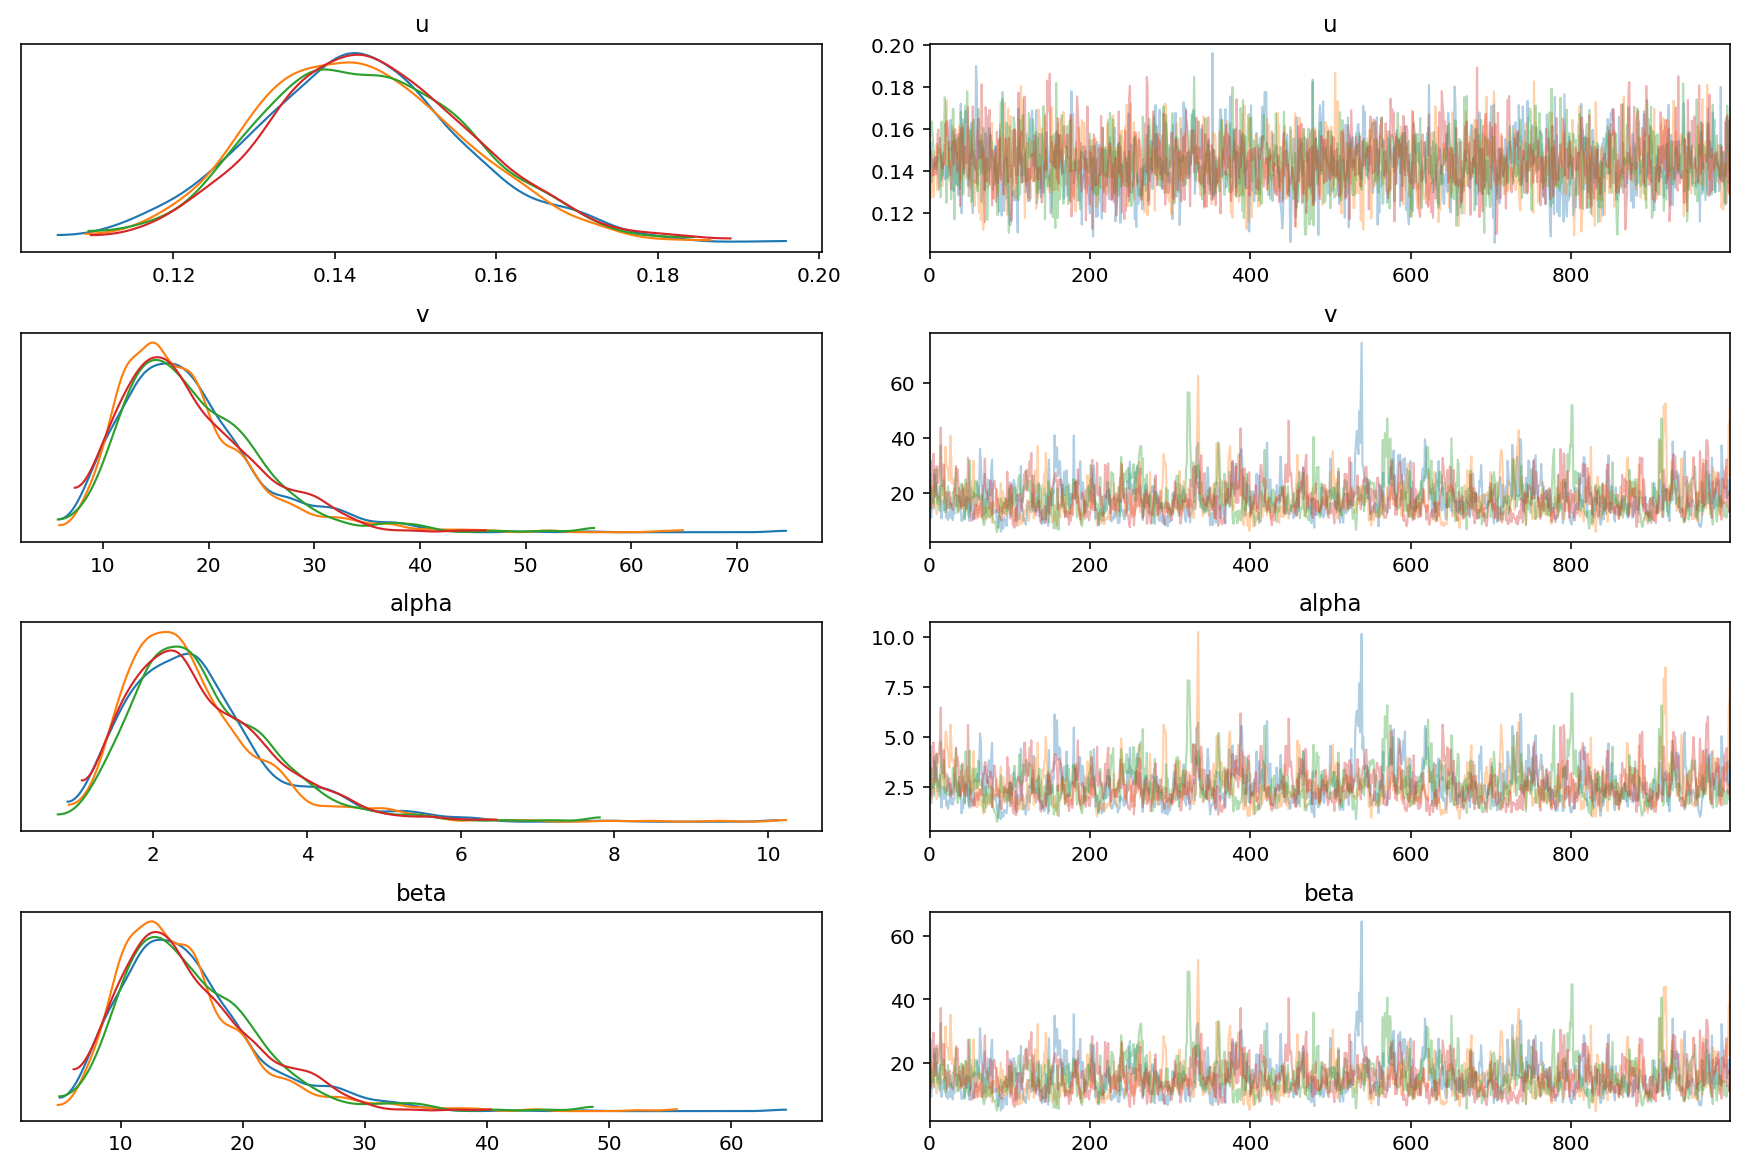

In [40]:
with model2:
    az.plot_trace(trace2, var_names=['u', 'v', 'alpha', 'beta'])

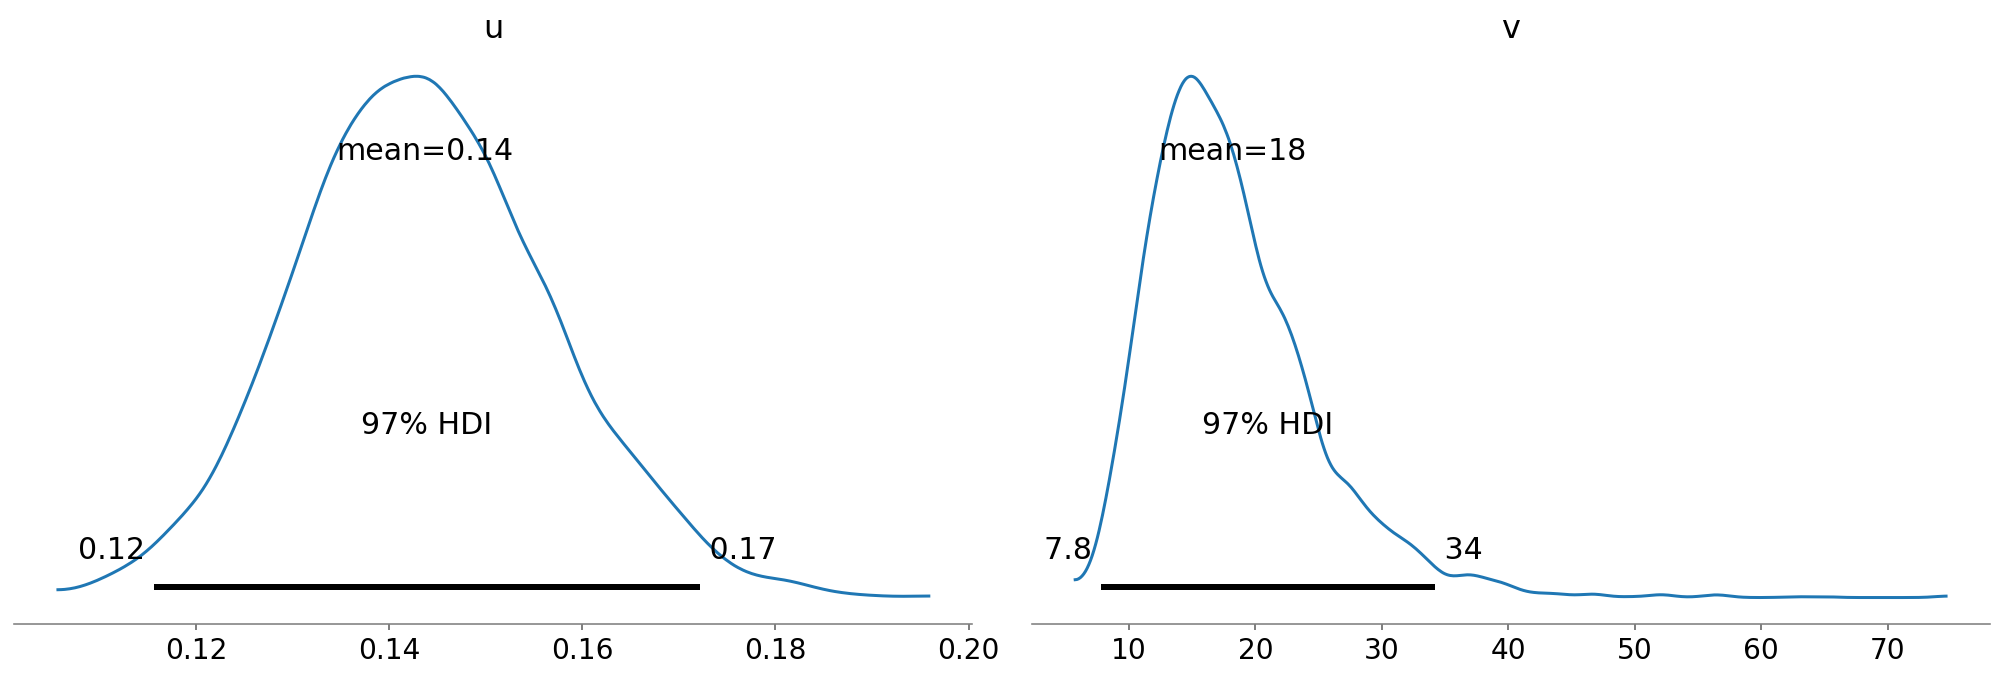

In [41]:
# the plot above can be drawn with arviz.
with model2:
    az.plot_posterior(trace2, var_names=['u', 'v'], hdi_prob=.97)

- The change due to another setting of the hyper-parameters seems reasonably small.
- Instead of Gamma distribution for $u$, we may use Pareto distribution (e.g. `pm.Pareto(1.5,1)`), or even a normal distribution with appropriate choice of its mean and variance parameters. Try to know Pareto.
- A mathematically rigourous choice of the prior for $\alpha$, $\beta$ is given in BDA3 or see [this presentation material](http://www.stat.cmu.edu/~brian/724/week06/lec15-mcmc.pdf). Normally, it is recommended to build a model with literally non-informative priors.
- Model comparison is another important topic in Bayesian statistics.

---

#### 2.12. Shrinkage
- Posterior mean tumor probability $\theta_s|Y$ **shrinks** sample proportions toward populationi mean.
    - In other words, $\theta_s|Y$ for study $s$ has moved from the mean of ratiosto each mean of studies.
- Shrinkage tends to be greater for smaller studies
    - The larger the sample size for a study, the more information we have for that study and the less information we need to borrow from the rest of the population. [Puff p.141, p135 first equation]
- Smaller studies **borrow strength** from other studies.

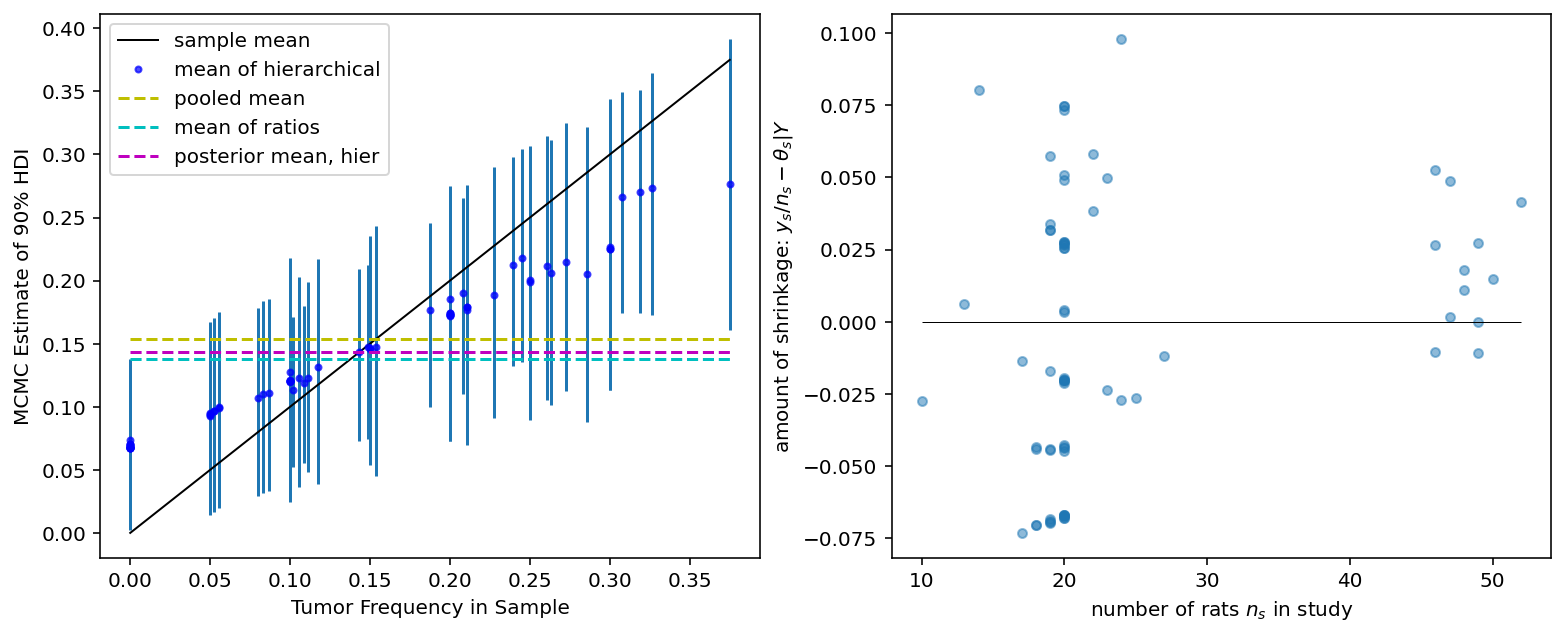

In [118]:
with model:
    # 90% High Density Intervals of 71 theta_s's, posterior
    hdi = az.hdi(trace, var_names='theta', hdi_prob=.9)
#     print(hdi.theta)
    hdi_theta = hdi.theta
    theta_mean = trace['theta'].mean(axis=0)
#
fig, axes = plt.subplots(1,2, figsize=(13,5))
ax=axes[0]
ax.set_xlabel('Tumor Frequency in Sample')
ax.set_ylabel('MCMC Estimate of 90% HDI')
for f, hdi in zip(r, hdi_theta):
    ax.vlines(x=f, ymin=hdi[0], ymax=hdi[1])
ax.plot([r[0], r[-1]], [r[0], r[-1]], color='k', linewidth=1, label='sample mean')
ax.plot(r, theta_mean, '.b', alpha=.7, label='mean of hierarchical')
ax.plot(r, np.full_like(r, theta_pmean), '--y', label='pooled mean')
ax.plot(r, np.full_like(r, r.mean()), '--c', label='mean of ratios')
ax.plot(r, np.full_like(r, trace['u'].mean()), '--m', label='posterior mean, hier')
ax.legend();
# ax.set_aspect(aspect=1, adjustable='box')

ax=axes[1]
shrinkage = np.vstack((n, r - np.full_like(n, theta_mean)))
ax.set_xlabel('number of rats $n_s$ in study')
ax.set_ylabel('amount of shrinkage: $y_s/n_s - θ_s|Y$')
# ax.plot(shrinkage[0], shrinkage[1], 'o')
ax.scatter(n, r - theta_mean, alpha=.5, s=20)
ax.hlines(y=0, xmin=n.min(), xmax=n.max(), color='k', linewidth=.5);

- This may be interpreted that: Each of the estimates $\theta_s|Y,n_s$ from the hierarchical model is in the middle of the posterior mean ($\hat v$) and sample proportion $\theta_s|y_s,n_s$.
- The result is one of the main reasons we consider hierarchcial models.

---

#### 2.13 Shrinkage and Order Reversals
- Shrinkage can change the rank ordering of point estimators
- Example:
    - Some sample frequencys (proportions) change in the hierarchical model and results in  rank reversals.
- This makes sense: sample proportions for smaller studies are more variable, so extreme values are more likely to be due to sample fluctuation.
---

#### 2.14. Pooled, Separate, and Hierarchical Anslyses for 2/25

In [164]:
# one of the study cases
i=22
ys, ns = y[i], n[i]
print(ys, ns)

2 25


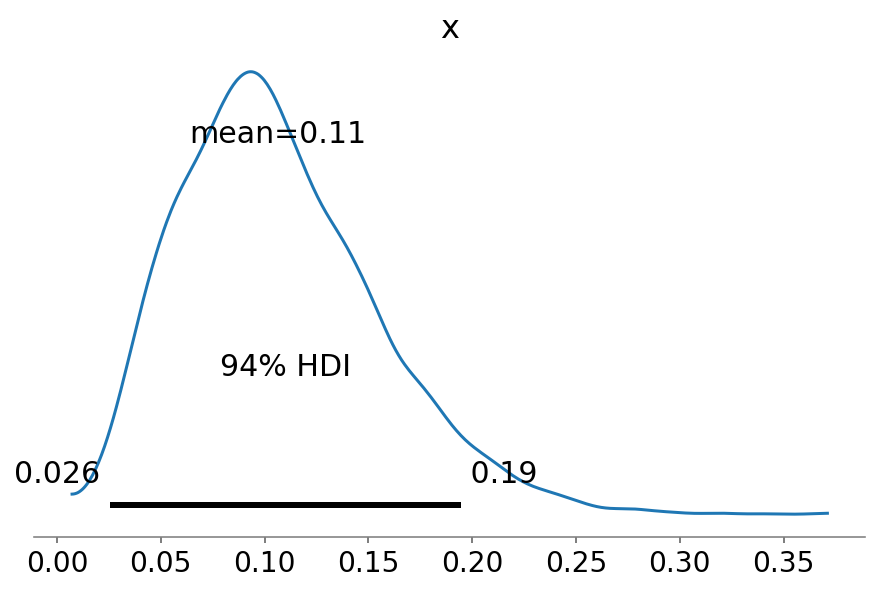

In [162]:
az.plot_posterior(trace['theta'][:,i]);

<BarContainer object of 11 artists>

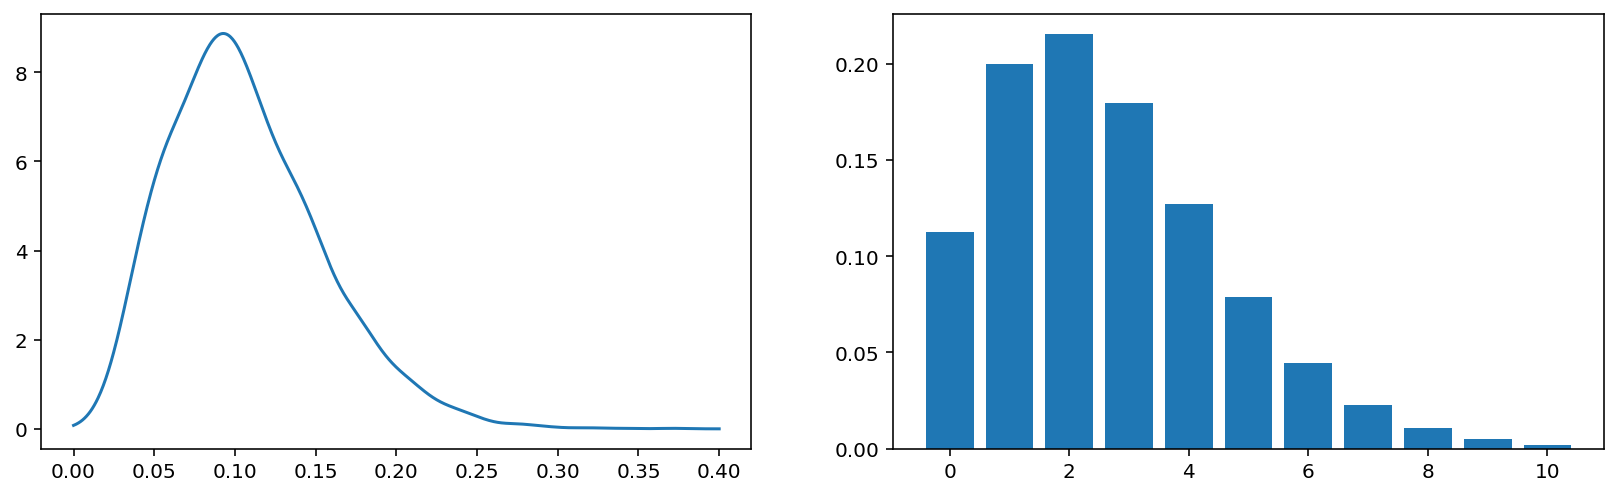

In [139]:
# how to draw posterior density and predictive distribution
draws = trace['theta'][:,i]
density = stats.gaussian_kde(draws)
fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].plot(x, density(x))

pmf = np.zeros((11))  # [0...10]
for th in draws:
    pmf_th = stats.binom(n=ns, p=th).pmf(np.arange(0,11))
    pmf += pmf_th
pmf /= len(draws)
axes[1].bar(np.arange(0,11), pmf)

In [189]:
def draw_posterior(draws, ns, ys, k=None):
    #
    density = stats.gaussian_kde(draws)

    # the posterior is simply beta
    post_2_25 = stats.beta(a=1+ys, b=1+ns-ys)

    x=np.linspace(0, .4, 1000)

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    # posterior densities
    pdf_2_25 = post_2_25.pdf(x)
    pdf_pool = post_pool.pdf(x)
    axes[0].plot(x, pdf_2_25, label=f'pdf_{ys}_{ns}');
    axes[0].plot(x, pdf_pool, label='pdf_pooled');
    axes[0].plot(x, density(x), label='pdf_hierachical(KDE)')
    axes[0].set_ylabel('Probability Density')
    axes[0].set_xlabel('Tumor Probability')
    axes[0].set_title(f'Posterior densities : Single, Pooled, Hierarchical.')
    axes[0].legend();

    def get_pmf(draws, k): 
        """ posterior predictive distribution, built from the sample average """
        pmf = np.zeros(k.shape)  # [0...10]
        for th in draws:
            pmf_th = stats.binom(n=ns, p=th).pmf(k)
            pmf += pmf_th
        pmf /= len(draws)
        return pmf  

    # posterior predictive distributions
    if k is None:
        k = np.arange(0,11)
    ppd_pool = stats.betabinom(n=ns, a=astar, b=bstar)
    pmf_pool = ppd_pool.pmf(k)
    ppd_2_25 = stats.betabinom(n=ns, a=1+ys, b=1+ns-ys)
    pmf_2_25 = ppd_2_25.pmf(k)
    pmf_hier = get_pmf(draws, k)

    width = .2
    axes[1].bar(k, pmf_2_25, label=f'ppd {ys}_{ns}', width=width, alpha=.7);
    axes[1].bar(k-width, pmf_pool, label='ppd pooled', width=width, alpha=.7);
    axes[1].bar(k+width, pmf_hier, label='ppd hier(KDE)', width=width, alpha=.7)
    axes[1].set_title('Posterior Predictive Distributions')
    axes[1].set_xlabel(f'Number of Tumors in {ns} rats')
    axes[1].legend();

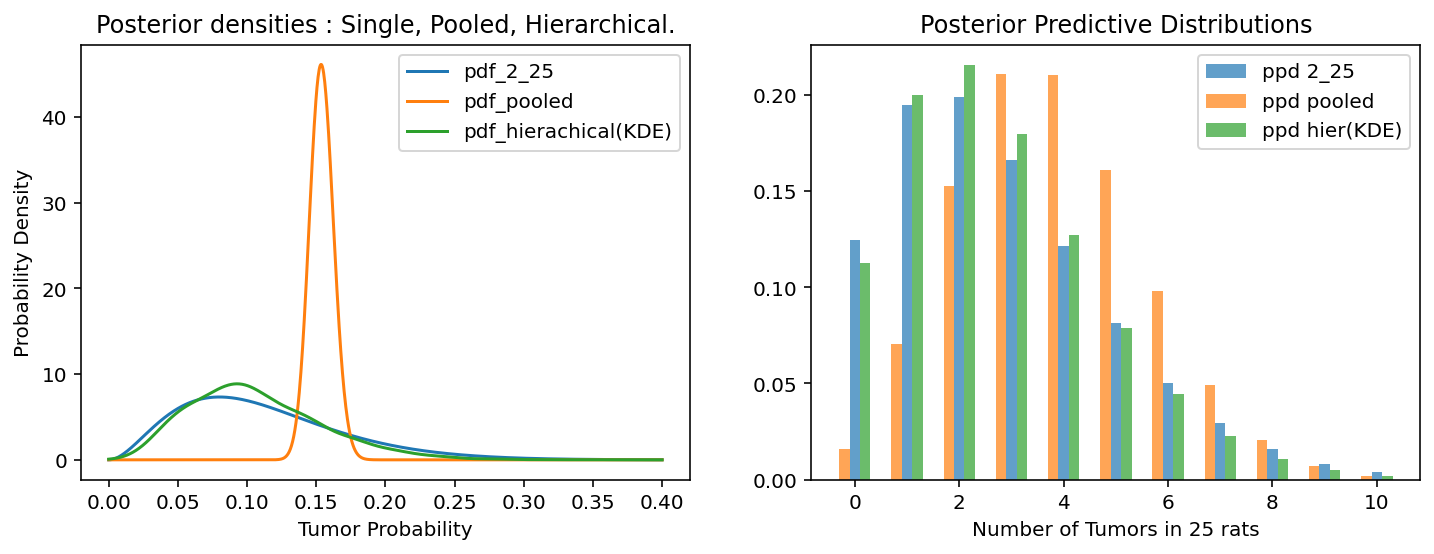

In [190]:
i=22
ys, ns = y[i], n[i]

draw_posterior(trace['theta'][:,i], ns, ys)

#### 2.15. Pooled, Separate, and Hierarchical Anslyses for 5/19

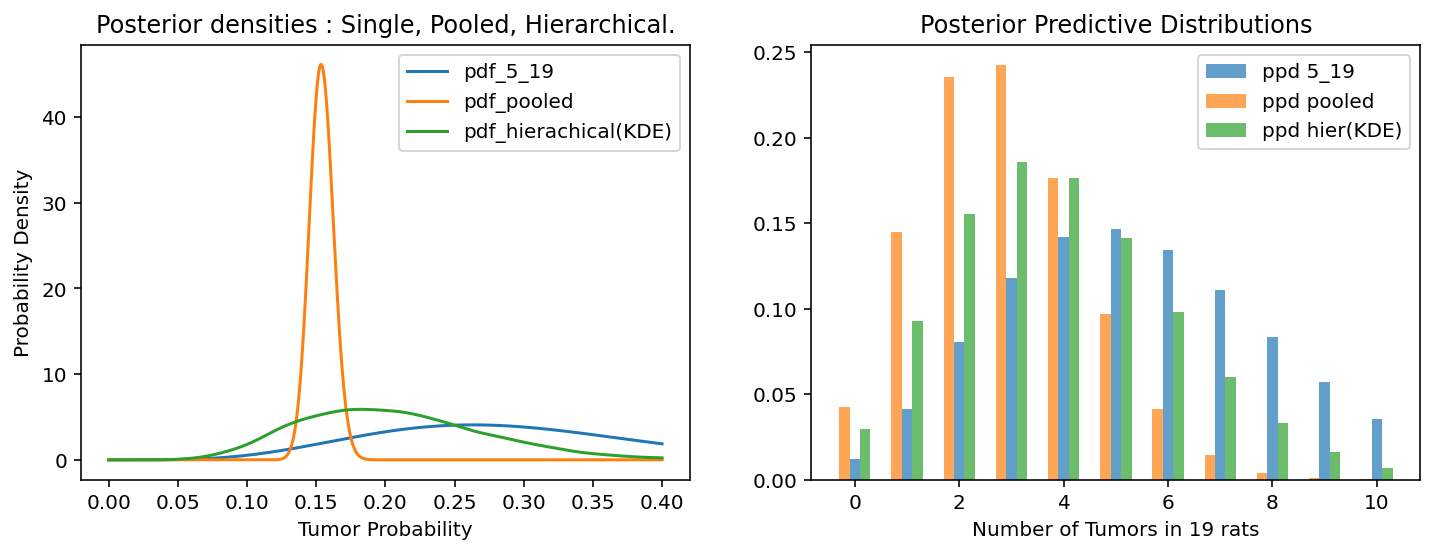

In [191]:
i = np.argmax((n==19) & (y==5))
ys, ns = y[i], n[i]

draw_posterior(trace['theta'][:,i], ns, ys)

#### 2.16. Pooled, Separate, and Hierarchical Anslyses for 12/49

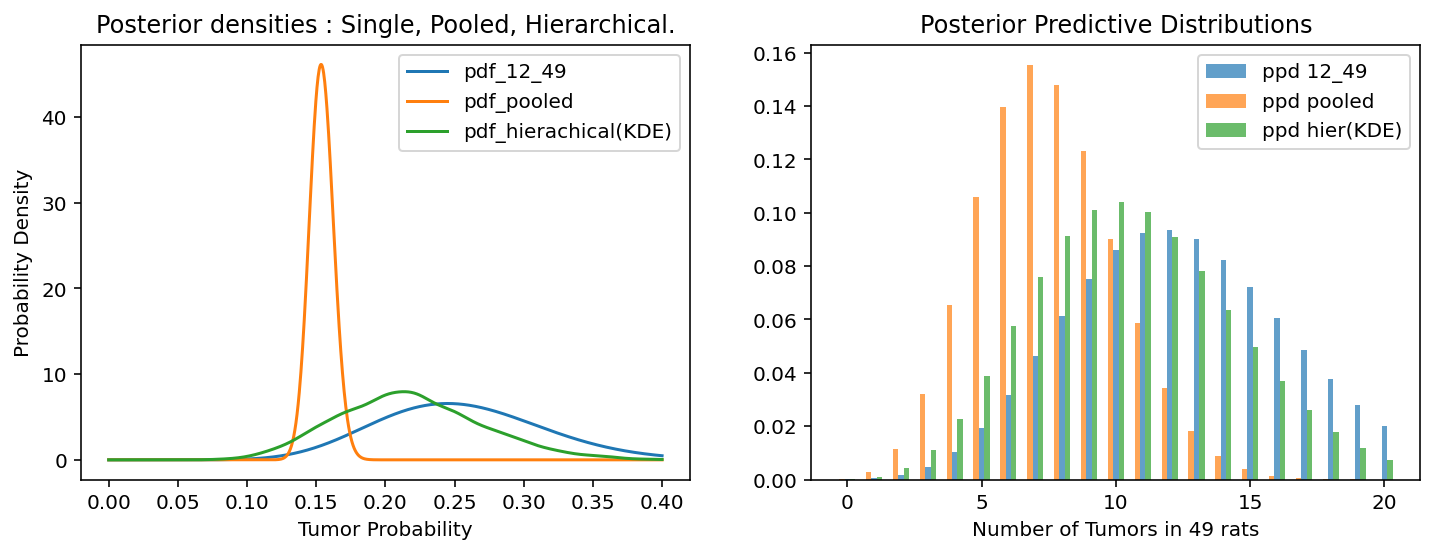

In [192]:
i = np.argmax((n==49) & (y==12))
ys, ns = y[i], n[i]

draw_posterior(trace['theta'][:,i], ns, ys, k=np.arange(0,21))

#### 2.17. Pooled, Separate, and Hierarchical Anslyses for 0/20

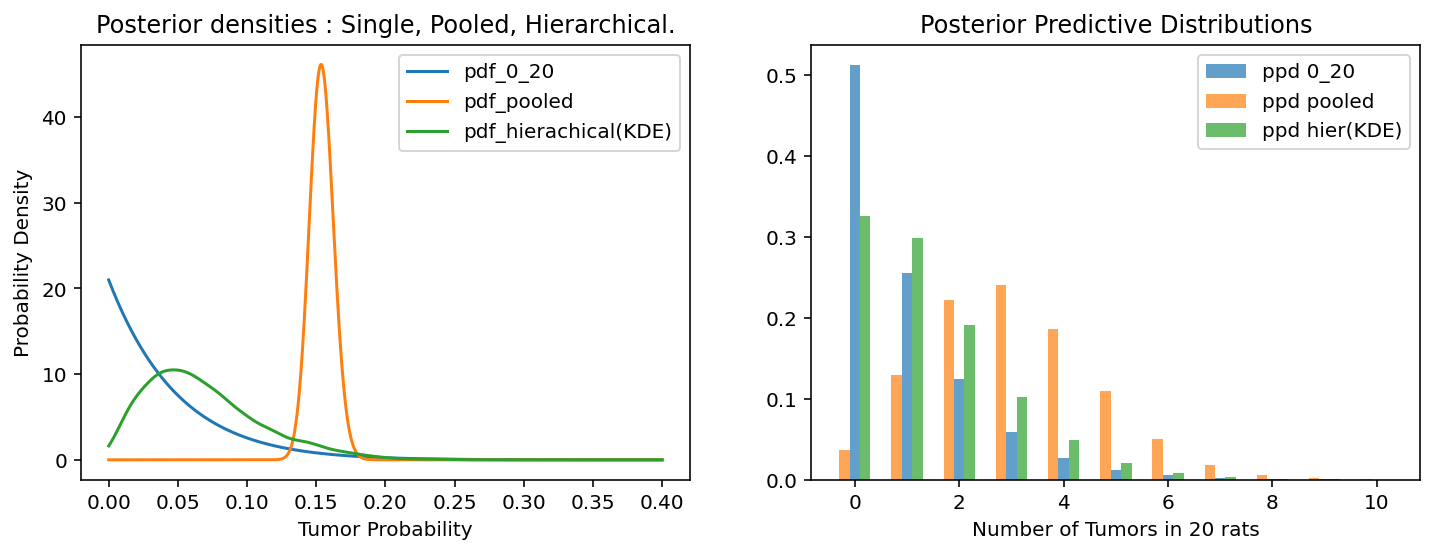

In [193]:
i = np.argmax((n==20) & (y==0))
ys, ns = y[i], n[i]

draw_posterior(trace['theta'][:,i], ns, ys)

# References

1. http://www.mas.ncl.ac.uk/~nmf16/teaching/mas3301/ ; Lecture notes, problems, and solutions. Good.
1. http://seor.vse.gmu.edu/~klaskey/SYST664/SYST664.html; PPT notes and course syllabus. Good

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w